# KMeans Clustering on 6-Month Heiken-Ashi Movement (Slope Similarity)

This notebook clusters assets by similar period Heiken-Ashi movement using KMeans, emphasizing slope/pattern similarity rather than absolute level.

Outputs:
- asset clusters (groups)
- cointegration summary (Engle-Granger) per cluster on the train window
- common daily price chart per cluster over full history

Time split:
- fit clustering on the training window (first 7 years)
- plots use full history


In [1]:
from __future__ import annotations

from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

from statsmodels.tsa.stattools import coint


In [2]:
# Resolve project root robustly
CWD = Path.cwd().resolve()
PROJECT_ROOT = None
for p in [CWD, *CWD.parents]:
    if (p / 'dataset').exists() and (p / 'src').exists():
        PROJECT_ROOT = p
        break
if PROJECT_ROOT is None:
    raise RuntimeError(f'Could not locate project root from CWD={CWD}')
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
print('PROJECT_ROOT:', PROJECT_ROOT)


PROJECT_ROOT: /home/anivarth/college/quant-task


In [3]:
from src.backtester.data import load_cleaned_assets, align_close_prices
from src.features.core import heiken_ashi

# Load all assets (100)
assets_ohlcv = load_cleaned_assets(cleaned_dir=str(PROJECT_ROOT / 'dataset' / 'cleaned'))
close_daily = align_close_prices(assets_ohlcv).sort_index()

# Time split for fitting clustering models
TRAIN_YEARS = 7
TEST_MONTHS = 18
start = pd.Timestamp(close_daily.index.min())
end = pd.Timestamp(close_daily.index.max())
train_end = start + pd.DateOffset(years=TRAIN_YEARS)
test_start = end - pd.DateOffset(months=TEST_MONTHS)

if train_end >= test_start:
    raise ValueError('Not enough history for requested time split')

print('date range:', start.date(), '->', end.date())
print('train_end:', train_end.date(), 'test_start:', test_start.date())


date range: 2016-01-25 -> 2026-01-16
train_end: 2023-01-25 test_start: 2024-07-16


ha_close shape: (21, 100)
X shape: (100, 14)
cluster sizes: {5: 54, 0: 7, 2: 29, 1: 2, 6: 1, 4: 3, 7: 3, 3: 1}


,cluster,n_assets,n_tested_pairs,pval_median,pval_10pct,pval_01pct
4,4,3,3,0.024873,0.016028,0.014038
0,5,54,300,0.251479,0.018989,0.000379
5,7,3,3,0.274853,0.074009,0.028819
2,2,29,300,0.288942,0.028037,0.003321
1,0,7,21,0.547087,0.097159,0.034140
3,1,2,1,0.586612,0.586612,0.586612


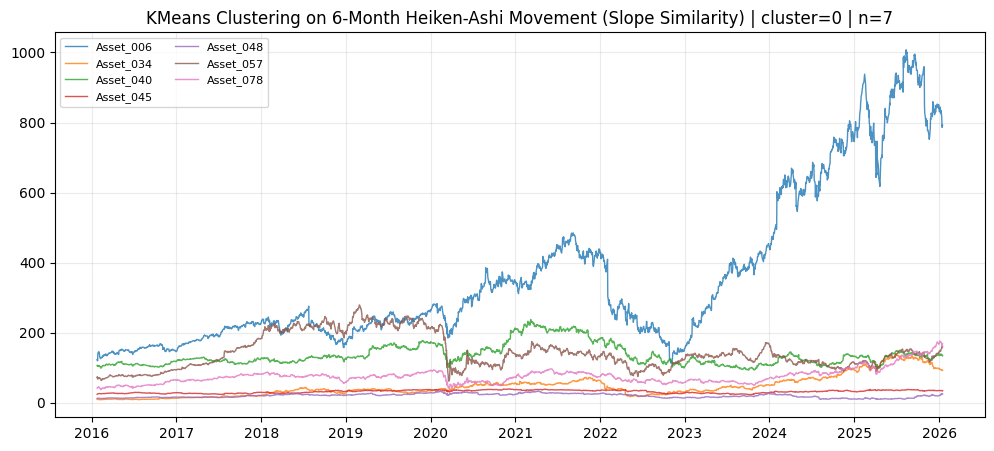

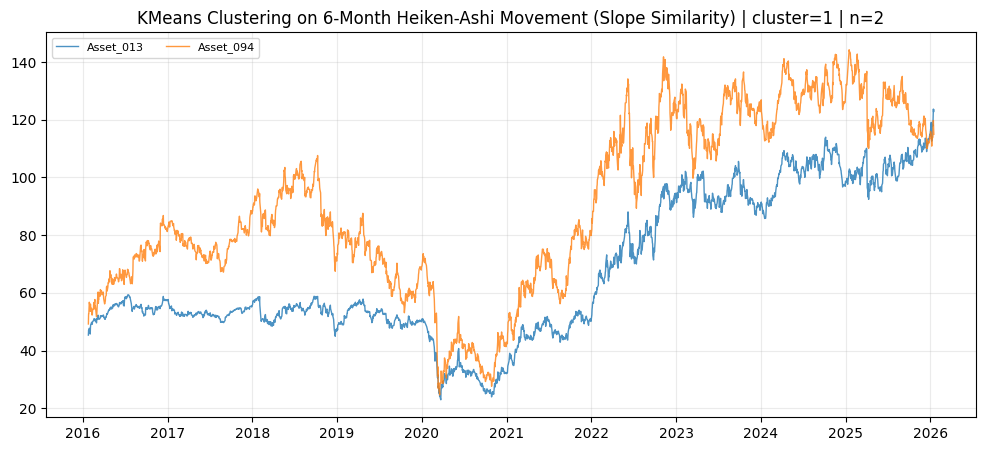

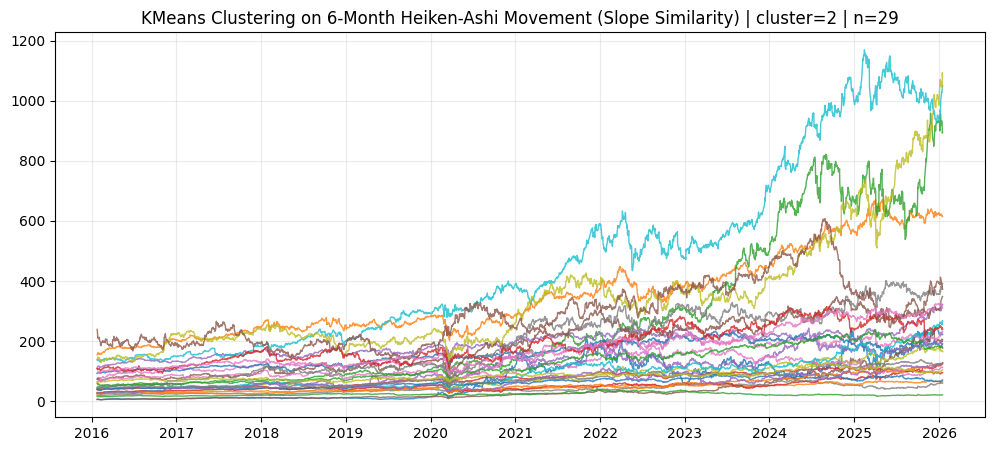

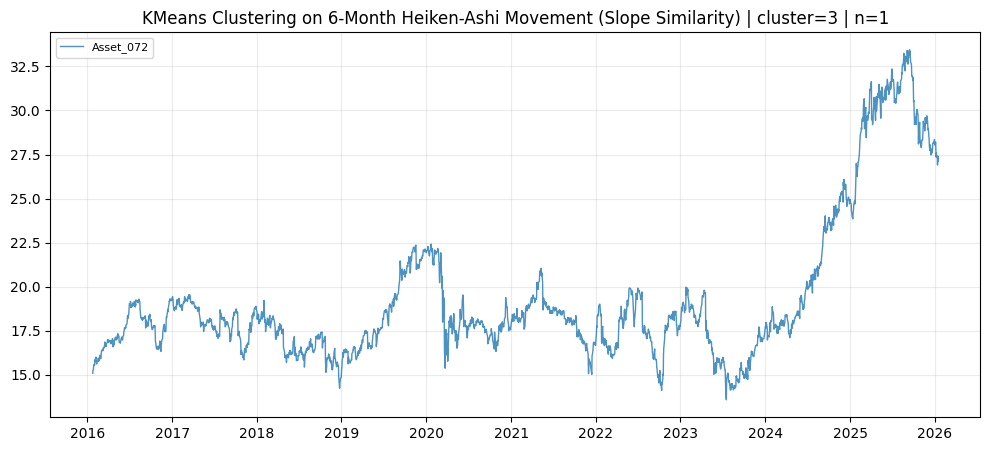

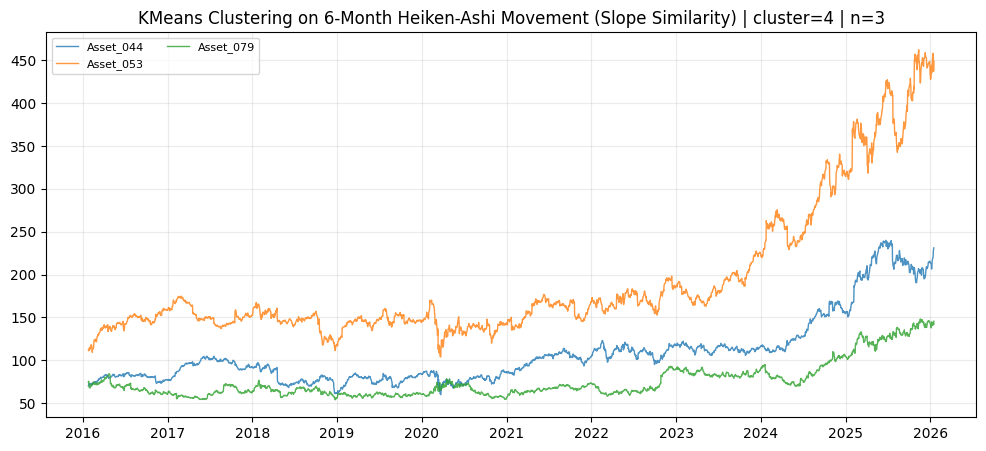

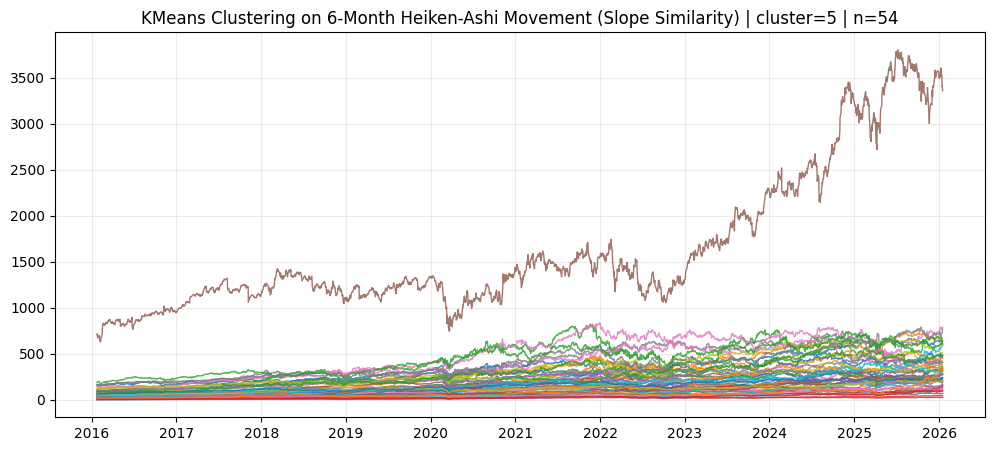

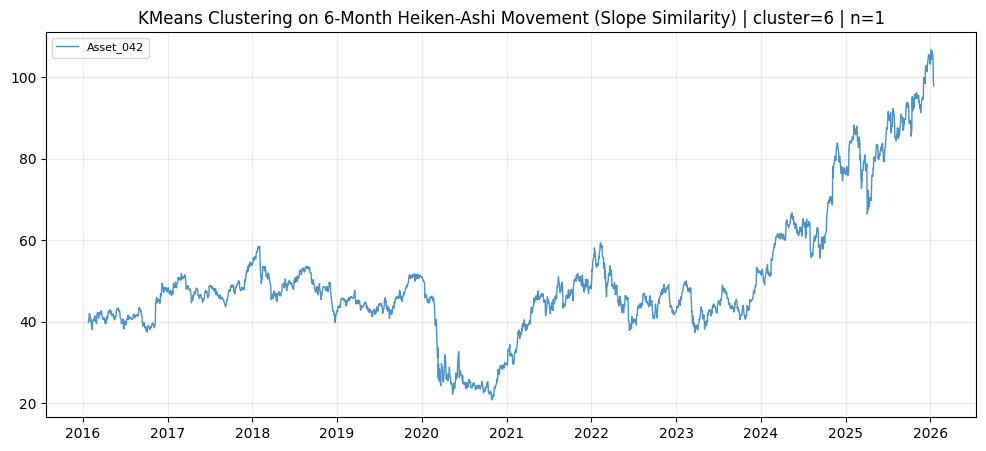

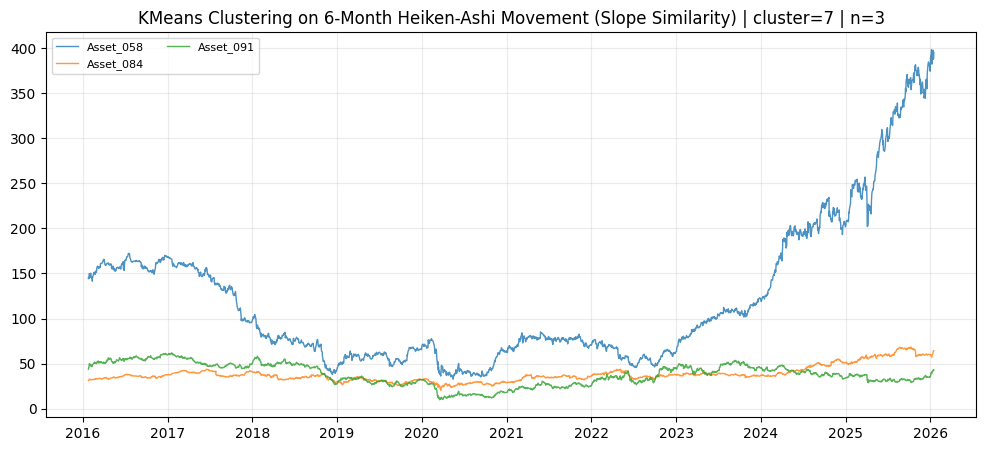

In [4]:
# Parameters
RULE = '6MS'
N_CLUSTERS = 8
SEED = 42

# Build 6MS Heiken-Ashi close series
def resample_ohlcv(df: pd.DataFrame, rule: str) -> pd.DataFrame:
    o = df['Open'].astype(float).resample(rule).first()
    h = df['High'].astype(float).resample(rule).max()
    l = df['Low'].astype(float).resample(rule).min()
    c = df['Close'].astype(float).resample(rule).last()
    v = df['Volume'].astype(float).resample(rule).sum() if 'Volume' in df.columns else None
    out = pd.DataFrame({'Open': o, 'High': h, 'Low': l, 'Close': c})
    if v is not None:
        out['Volume'] = v
    return out.dropna(subset=['Open','High','Low','Close'])

def build_heiken_ashi_close(assets: dict[str, pd.DataFrame], rule: str) -> pd.DataFrame:
    cols = {}
    for sym, df in assets.items():
        r = resample_ohlcv(df, rule)
        ha = heiken_ashi(r['Open'], r['High'], r['Low'], r['Close'])
        cols[sym] = ha['ha_close']
    ha_close = pd.DataFrame(cols).sort_index()
    return ha_close

ha_close = build_heiken_ashi_close(assets_ohlcv, RULE)
print('ha_close shape:', ha_close.shape)

# Fit clustering on train window using HA slope-shape vectors
def slope_shape_matrix(price_df: pd.DataFrame, *, start_dt: pd.Timestamp, end_dt: pd.Timestamp) -> tuple[np.ndarray, list[str], pd.DatetimeIndex]:
    # Build a per-asset shape vector emphasizing slope/pattern, not level.
    #
    # Steps:
    # - take log price
    # - subtract first value (start at 0)
    # - scale by std of first differences (remove magnitude)
    # - L2-normalize vectors (focus on shape)

    px = price_df.loc[start_dt:end_dt].copy()
    px = px.dropna(axis=1, how='all')

    px = px.ffill().bfill()
    px = px.dropna(axis=1, how='any')

    logp = np.log(px.to_numpy(dtype=float))
    logp = logp - logp[0:1, :]

    d = np.diff(logp, axis=0)
    scale = np.std(d, axis=0, ddof=0)
    scale = np.where(scale == 0.0, 1.0, scale)
    logp = logp / scale[None, :]

    X = logp.T
    X = normalize(X, norm='l2')

    assets = list(px.columns)
    return X, assets, px.index

X, assets, idx = slope_shape_matrix(ha_close, start_dt=start, end_dt=train_end)
print('X shape:', X.shape)

def cluster_assets_kmeans(X: np.ndarray, assets: list[str], *, n_clusters: int, seed: int = 42) -> dict[int, list[str]]:
    km = KMeans(n_clusters=n_clusters, random_state=seed, n_init=10)
    labels = km.fit_predict(X)
    groups: dict[int, list[str]] = {}
    for a, lab in zip(assets, labels):
        groups.setdefault(int(lab), []).append(a)
    return groups


def plot_cluster_prices(groups: dict[int, list[str]], close_daily: pd.DataFrame, *, title_prefix: str, max_assets_per_plot: int | None = None) -> None:
    for k in sorted(groups.keys()):
        syms = groups[k]
        if max_assets_per_plot is not None:
            syms = syms[:max_assets_per_plot]

        df = close_daily.loc[:, [s for s in syms if s in close_daily.columns]].dropna(how='all')
        if df.empty:
            continue

        plt.figure(figsize=(12, 5))
        for s in df.columns:
            plt.plot(df.index, df[s].astype(float), linewidth=1.0, alpha=0.8, label=str(s))
        plt.title(f"{title_prefix} | cluster={k} | n={len(groups[k])}")
        plt.grid(True, alpha=0.25)
        if len(df.columns) <= 12:
            plt.legend(ncol=2, fontsize=8)
        plt.show()

groups = cluster_assets_kmeans(X, assets, n_clusters=N_CLUSTERS, seed=SEED)
print('cluster sizes:', {k: len(v) for k, v in groups.items()})

# Cointegration summary on train window (daily close, stability check)
def cointegration_summary_for_groups(groups: dict[int, list[str]], close_daily: pd.DataFrame, *, start_dt: pd.Timestamp, end_dt: pd.Timestamp, max_assets: int = 25) -> pd.DataFrame:
    rows = []
    px = close_daily.loc[start_dt:end_dt].ffill().bfill()
    for cid, syms in groups.items():
        syms_use = [s for s in syms if s in px.columns][:max_assets]
        n = len(syms_use)
        if n < 2:
            continue
        pvals = []
        for i in range(n):
            for j in range(i + 1, n):
                y = np.log(px[syms_use[i]].astype(float))
                x = np.log(px[syms_use[j]].astype(float))
                try:
                    _score, pval, _ = coint(y, x)
                except Exception:
                    continue
                pvals.append(float(pval))
        if not pvals:
            continue
        pvals_sorted = sorted(pvals)
        rows.append(
            {
                'cluster': int(cid),
                'n_assets': int(len(syms)),
                'n_tested_pairs': int(len(pvals)),
                'pval_median': float(np.median(pvals_sorted)),
                'pval_10pct': float(np.quantile(pvals_sorted, 0.10)),
                'pval_01pct': float(np.quantile(pvals_sorted, 0.01)),
            }
        )
    return pd.DataFrame(rows).sort_values(['pval_median', 'pval_10pct'], ascending=True)

summary = cointegration_summary_for_groups(groups, close_daily, start_dt=start, end_dt=train_end)
display(summary)

# Plot daily prices for each cluster (full history)
plot_cluster_prices(groups, close_daily, title_prefix='KMeans Clustering on 6-Month Heiken-Ashi Movement (Slope Similarity)')
